<a href="https://colab.research.google.com/github/Imperial-lord/sdn-controllers-load-balancing/blob/main/SDN_Load_Balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
####### Graph Building using data from Arnes.gml ########
import networkx as nx
import time
import random
import math
import numpy as np
import pandas as pd

from math import radians, cos, sin, asin, sqrt

####### Data collection, cleaning, and handling corner cases #######

k = int(input("Enter the number of controllers to allocate: "))
start = time.time()
graph = nx.read_gml('/content/drive/MyDrive/BTP Documents/Arnes.gml', label='id')

lat = nx.get_node_attributes(graph, "Latitude")
lon = nx.get_node_attributes(graph, "Longitude")

# Remove bad nodes from 'graph'
for node in list(graph.nodes):
    # removing nodes 
    # (a) with undefined latitude or longitude  
    # (b) that are isolated
    check_bad_node = lat.get(node) == None or lon.get(node) == None or nx.is_isolate(graph,node)
    if check_bad_node == True:
        graph.remove_node(node)


def dist_between_nodes(node_1, node_2):
    '''Compute distance between any 2 nodes of 'graph' using Haversine formula

    Args:
        node_1 (int): The first among the 2 graph nodes 
        node_2 (int): The second among the 2 graph nodes 

    Returns:
        dist: distanct between the two nodes
    '''
    lat_1 = radians(lat.get(node_1))
    lat_2 = radians(lat.get(node_2))
    lon_1 = radians(lon.get(node_1))
    lon_2 = radians(lon.get(node_2))

    # Applying Haversine formula
    dlon = lon_2 - lon_1
    dlat = lat_2 - lat_1
    a = sin(dlat/2)**2 + cos(lat_1)*cos(lat_2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))

    # Mean radius of Earth
    R = 6371.009
    dist = c*R

    return dist

# Assigning weights (based on distance) to the edges of the graph
for node in list(graph.nodes):
    for neighbor in list(graph.neighbors(node)):
        graph[node][neighbor]['weight'] = dist_between_nodes(node, neighbor)

# Removing edges with no weights assigned
for edge in list(graph.edges):
    if 'weight' not in graph.edges[edge] == False:
        graph.remove_edge(edge[0],edge[1])

print(nx.info(graph))
n = nx.number_of_nodes(graph)

####### Graph building and Controllers' Cluster formation #######

# Store the graph as an adjacency list
adj_list = [];
for i in range(0,n):
    adj_list.append([])

for edge in graph.edges:
    i,j = edge
    adj_list[i].append(j)
    adj_list[j].append(i)

# Random sampling for controller index selection
controller = random.sample(range(0,n),k)

# List of lists represents index of switches in particular controller 
# e.g. [[s1,s2],[s3,s4],[s5]] controller distribution set
lol = []
for i in range(0,k):
    lol.append([])

# Controllers set
controller_max = list(controller)
print("\nControllers: \n{}\n".format(controller))

def BFS(queue, adj_list, listx):
    '''Performs a breadth first search in the graph
    '''
    while queue:
        p = queue.pop(0)
        u, w = p
        for v in adj_list[u]:
            if listx[v] == math.inf:
                listx[v] = w + 1
                queue.append((v, w + 1))
    return listx

index = 0
for j in range(0, k):
    listx = n*[math.inf]
    listx[controller[index]] = 0
    queue = []
    queue.append((controller[index], 0))
    listx = BFS(queue, adj_list, listx)
    lol[j] = listx
    index += 1

transpose_list = np.transpose(lol).tolist()
minumum_pos = []

for x in transpose_list:
    min_ele = n+5
    for i in range(0, len(x)):
        if x[i] < min_ele:
            min_ele = x[i]
    ts = []
    for i in range(0, len(x)):
        if(x[i] == min_ele):
            ts.append(i)
    minumum_pos.append(random.choice(ts))

final = []
controller_set = []
for i in range(0, k):
    controller_set.append([])

for i in range(0, n):
    final.append((i, controller[minumum_pos[i]]))
    controller_set[minumum_pos[i]].append(i)

print('Cluster set for each controller: \n{}\n'.format(controller_set))

def floyd_warshall(graph):
    d = defaultdict(set)
    inf = float('inf')

    # Initialising distance between all nodes as infinity
    for node1 in graph.nodes:
        for node2 in graph.nodes:
            d[(node1, node2)] = inf

    # Changing the distance between adjacent nodes
    for edge in graph.edges:
        # Undirected graph
        d[(edge[0], edge[1])] = graph.edges[edge]['weight']
        d[(edge[1], edge[0])] = graph.edges[edge]['weight']
    for node in graph.nodes:
        d[(node, node)] = 0

    # Updating the matrix
    for node1 in graph.nodes:
        for node2 in graph.nodes:
            for node3 in graph.nodes:
                if d[(node2, node3)] > d[(node2, node1)] + d[(node1, node3)]:
                    d[(node2, node3)] = d[(node2, node1)] + d[(node1, node3)]
                    d[(node3, node2)] = d[(node2, node3)]

    return d


dist = floyd_warshall(graph)

# Keeping another copy of the controller set for Q-learning
controller_set_max = list(controller_set)

frame = pd.read_csv('/content/drive/MyDrive/BTP Documents/data.csv')
nodes = list(graph.nodes)
random.shuffle(nodes)
frame = frame.rename(columns=dict(zip(frame.columns, nodes)))

load_array = []
for i in frame.index:
    Load = dict(frame.loc[i])
    load_array.append(Load)
    

Enter the number of controllers to allocate: 4
Graph with 34 nodes and 46 edges

Controllers: 
[32, 25, 31, 9]

Cluster set for each controller: 
[[1, 13, 26, 27, 32, 33], [2, 3, 24, 25], [11, 12, 28, 29, 30, 31], [0, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]



In [19]:
####### Common functions and calculations for controller load #######

# Classify the domain based on load as overloaded or underloaded
def classify_domain(cluster_load, no_of_controller):
    # Mean load
    mean_load = sum([y for x, y in cluster_load.items()])
    mean_load = mean_load/no_of_controller
    O_domain = []
    I_domain = []
    for controller1, controller_load in cluster_load.items():
        if(controller_load > mean_load):
            O_domain.append(controller1)
        else:
            I_domain.append(controller1)
    return [O_domain, I_domain, mean_load]


# Update the load
def update_load(cluster_load, i, current_state, cnt, current_switch):
    cluster_load[current_state] = cluster_load[current_state] - \
        load_array[i][current_switch]
    cluster_load[cnt] = cluster_load[cnt]+load_array[i][current_switch]

# Return all available actions in state given as an argument
def available_actions(k):
    return [item for item in range(0, k)]

# Calculate the mean load
def load_rate(cluster_load, mean_load, no_of_controller):
    s = 0
    for controller1, controller_load in cluster_load.items():
        s = s + abs(controller_load - mean_load)
    s = s/no_of_controller
    return s

# Calculate load ratio
def load_ratio_calculate(controller1, cluster_load):
    return cluster_load[controller1]


In [20]:
####### Defining functions for population of cluster load array 
####### switch selection, migration, and random actions ####### 

# Populating cluster load array
# {c1:36363663, c2:3234325, c3:32523525, c4:3523535, c5:3542646}
def calculate_load(time_step):
    cluster_load = defaultdict(lambda: 0)
    for center in controller:
        # print(center)
        for node in controller_set:
            # print(node)
            if center in node:
                for switch in node:
                    # print(switch)
                    cluster_load[center] += load_array[time_step][switch]
    return cluster_load

# For switch selection randomly
def switch_select(ind, current_cont):
    if(len(controller_set[ind]) == 1):
        return -1
    x = random.choice(controller_set[ind])
    # To avoid controller to be selected itself
    while(x == current_cont):
        x = random.choice(controller_set[ind])
    return x

# Random controller selection
def random_action(available_act, control):
    next_action = int(np.random.choice(available_act, 1))
    while(next_action == control):
        next_action = int(np.random.choice(available_act, 1))
    return next_action

# Migration of switch from source to target
def migrate_switch(ind_of_controller, target_controller, current_switch):
    controller_set[ind_of_controller].remove(current_switch)
    controller_set[target_controller].append(current_switch)

# Selection of switch
def switch_select_mx(ind, current_cont):
    if(len(controller_set[ind]) == 1):
        return -1
    x = random.choice(controller_set[ind])
    while(x == current_cont):
        x = random.choice(controller_set[ind])
    return x
    

In [21]:
from collections import defaultdict

# Random Approch
# For making graph
x1 = []  # For storing time steps
y1 = []  # For load balance rate
z1 = []  # For number of switches

load_rate_array = []  # (load balance rate, number of switches)
migration_cost_random = 0
migration_array_random = []
normalize = 10**9
# Training over 5,000 iterations(time steps).
for i in range(0, 1000):
    print('At time steps =', i)

    # default dictionary to store load of each controller{k:load(k) for each k}
    cluster_load = defaultdict(lambda: 0)
    cluster_load = calculate_load(i)
    switch_array = []

    # To classify the controllers on the basis of load taking mean_load as ideal
    # O_domain = Set of overloded domain
    # I_domain = Set of undeloaded domain
    O_domain, I_domain, mean_load = classify_domain(cluster_load, k)
    print('Overloaded domains are = ', O_domain)

    migration_cost_random = 0
    # loop until all O_domain are balanced
    while(len(O_domain) >= 1):

        # Picking a random overloaded domain
        current_state = random.choice(O_domain)
        O_domain.remove(current_state)

        # do until the choosen controller becomes balanced i.e. its load becomes less than or equal to mean_load
        while(cluster_load[current_state] > mean_load):

            #state = current_state
            print('Balancing controller', current_state)

            print('Controller\tController_Load')
            for C, C_load in cluster_load.items():
                print(C, ' :\t', C_load)

            # for switch selection
            ind_of_controller = controller.index(current_state)
            current_switch = switch_select(ind_of_controller, current_state)
            print('Source controller set ', current_state,
                  ' : ', controller_set[ind_of_controller])

            if(current_switch == -1):
                break

            print('switch selected is', current_switch)
            switch_array.append(current_switch)

            # available action and choosing random from it
            available_act = available_actions(k)
            target_controller = random_action(available_act, ind_of_controller)
            print('Target controller set ',
                  controller[target_controller], ' : ', controller_set[target_controller])

            migrate_switch(ind_of_controller,
                           target_controller, current_switch)
            update_load(cluster_load, i, current_state,
                        controller[target_controller], current_switch)

            if(dist[current_state, current_switch] - dist[controller[target_controller], current_switch] > 0):
                migration_cost_random = migration_cost_random + 6*(2*dist[controller[target_controller], current_state] + load_array[i][current_switch]*(
                    abs(dist[current_state, current_switch] - dist[controller[target_controller], current_switch])))
            else:
                migration_cost_random = migration_cost_random + 6 * \
                    (2*dist[controller[target_controller], current_state])

            print('\n')

    migration_array_random.append(migration_cost_random/normalize)
    # load balancing rate
    l_rate = load_rate(cluster_load, mean_load, k)

    y1.append(l_rate)
    x1.append(i)
    load_rate_array.append([l_rate, len(switch_array)])
    z1.append(len(switch_array))
    print('At Time step ', i, ' number of switch migrated are : ', len(switch_array))
    print('Migrated Switches are ', switch_array)

    print('---------------------------------------------------------------------------------------------------------------------------')


Streaming output truncated to the last 5000 lines.
At Time step  906  number of switch migrated are :  5
Migrated Switches are  [15, 3, 13, 11, 27]
---------------------------------------------------------------------------------------------------------------------------
At time steps = 907
Overloaded domains are =  [32, 9]
Balancing controller 9
Controller	Controller_Load
32  :	 5303356.817299999
25  :	 3877845.3284
31  :	 4270557.6572511
9  :	 5336754.617917101
Source controller set  9  :  [9, 10, 18, 0, 1, 19, 33, 13, 11]
switch selected is 13
Target controller set  31  :  [31, 4, 21, 12, 17, 23, 22, 24, 5]


Balancing controller 9
Controller	Controller_Load
32  :	 5303356.817299999
25  :	 3877845.3284
31  :	 4685864.4122511
9  :	 4921447.862917101
Source controller set  9  :  [9, 10, 18, 0, 1, 19, 33, 11]
switch selected is 11
Target controller set  32  :  [32, 30, 28, 14, 7, 20, 3, 27]


Balancing controller 9
Controller	Controller_Load
32  :	 5304036.999023099
25  :	 3877845.3284

In [22]:
# For Q-learning
def calculate_load_max(time_step):
    cluster_load = defaultdict(lambda: 0)
    for center in controller_max:
        # print(center)
        for node in controller_set_max:
            # print(node)
            if center in node:
                for switch in node:
                    # print(switch)
                    cluster_load[center] += load_array[time_step][switch]
    return cluster_load

# max_load switch select


def switch_max_select(ind, current_cont, time_st):
    if(len(controller_set_max[ind]) == 1):
        return -1
    x = controller_set_max[ind]
    load_x = []
    for i in x:
        load_x.append((load_array[time_st][i], i))
    load_x.sort(reverse=True)
    print(load_x)
    if(load_x[0][1] == current_cont):
        return load_x[1][1]
    return load_x[0][1]

# return I domain


def find_underloaded(cluster_load, mean_load):
    I_domain = []
    for controller1, controller_load in cluster_load.items():
        if(controller_load < mean_load):
            I_domain.append(controller1)
    return I_domain


def sample_next_action(available_act, control, epsilon, Q_greedy):

    ran = np.random.random()
    next_action = -1

    if(ran < epsilon):
        next_action = int(np.random.choice(available_act, 1))
        while(next_action == control):
            next_action = int(np.random.choice(available_act, 1))
    else:
        ls = []
        for i in available_act:
            ind = controller_max.index(i)
            if(ind != control):
                ls.append(ind)

        max_ele = Q_greedy[control][ls[0]]
        next_action = controller_max[ls[0]]
        if(len(ls) > 1):
            for i in range(1, len(ls)):
                if(max_ele < Q_greedy[control][ls[i]]):
                    max_ele = Q_greedy[control][ls[i]]
                    next_action = controller_max[ls[i]]
    return next_action


def deviation_calculate(R_ini, R_tar):
    mean = (R_ini + R_tar)/2
    x = math.sqrt(((R_ini - mean)**2 + (R_tar - mean)**2)/2)
    x = x/mean
    return x


def migrate_switch_max(ind_of_controller, target_controller, current_switch):
    controller_set_max[ind_of_controller].remove(current_switch)
    controller_set_max[target_controller].append(current_switch)
    return

In [23]:
# Q-matrix

# size equals to number of states.
Q_greedy = np.ones([k, k])

# Q(state,action) = Q[current_state,action] + alpha*(R[current_state,action] + gamma*max_value - Q[current_state,action])

# learning parameters
# Learning rate
alpha = 0.6
# Gamma
# between 0 and 1
gamma = 0.7


def update_greedyQL(current_state, action, gamma, reward):
    # selecting maximum in target controller considering as new state

    l = []
    maximum_ele = Q_greedy[action, 0]
    t = range(1, len(Q_greedy[action, ]))
    for i in t:
        if(Q_greedy[action, i] >= maximum_ele):
            maximum_ele = Q_greedy[action, i]

    for i in range(0, len(Q_greedy[action, ])):
        if(Q_greedy[action, i] == maximum_ele):
            l.append(i)

    # if more than one maximum
    max_index = np.random.choice(l)

    # for max term
    max_value = Q_greedy[action, max_index]

    Q_greedy[current_state, action] = Q_greedy[current_state, action] + \
        alpha*(reward + gamma*max_value - Q_greedy[current_state, action])
    print('Q value  = ', Q_greedy[current_state, action])
    return


# For making graph
x2 = []  # For storing time steps
y2 = []  # For load balance rate
z2 = []  # For number of switches

reward_array = []
load_rate_array_QL = []

migration_cost = 0
migration_array_greedy = []

epsilon = 0.001
epsilon_dec = 0.0025
epsilon_min = 0.05

load_controller = []

# Training over 5,000 iterations(time steps).
for i in range(0, 1000):
    print('At time steps =', i)

    # default dictionary to store load of each controller{k:load(k) for each k}
    cluster_load = defaultdict(lambda: 0)

    cluster_load = calculate_load_max(i)
    switch_array = []

    # To classify the controllers on the basis of load taking mean_load as ideal
    # O_domain = Set of overloded domain
    # I_domain = Set of undeloaded domain
    O_domain, I_domain, mean_load = classify_domain(cluster_load, k)
    print('Overloaded domains are = ', O_domain)

    #migration_cost = 0

    # loop until all O_domain are balanced
    while(len(O_domain) >= 1):

        # Picking a random overloaded domain
        current_state = random.choice(O_domain)
        O_domain.remove(current_state)

        # do until the choosen controller becomes balanced i.e. its load becomes less than or equal to mean_load
        while(cluster_load[current_state] > mean_load):

            print('Balancing controller', current_state)

            print('Controller\tController_Load')
            for C, C_load in cluster_load.items():
                print(C, ' :\t', C_load)

            # for switch selection
            ind_of_controller = controller_max.index(current_state)

            current_switch = switch_max_select(
                ind_of_controller, current_state, i)
            print('Source controller set ', current_state,
                  ' : ', controller_set_max[ind_of_controller])

            if(current_switch == -1):
                break
            print('switch selected is', current_switch)
            switch_array.append(current_switch)

            ######
            Underloaded_domain = find_underloaded(cluster_load, mean_load)
            print('Underloaded domain are = ', Underloaded_domain)

            # available action and choosing in epsilon greedy approch
            target = sample_next_action(
                Underloaded_domain, ind_of_controller, epsilon, Q_greedy)
            target_controller = controller_max.index(target)

            print('Target controller set ',
                  controller_max[target_controller], ' : ', controller_set_max[target_controller])
            print('Mean Load = ', mean_load)

            # Reward calculation
            R_initial = load_ratio_calculate(current_state, cluster_load)
            R_target = load_ratio_calculate(
                controller_max[target_controller], cluster_load)
            D_t = deviation_calculate(R_initial, R_target)

            migrate_switch_max(ind_of_controller,
                               target_controller, current_switch)
            update_load(cluster_load, i, current_state,
                        controller_max[target_controller], current_switch)

            R_initial = load_ratio_calculate(current_state, cluster_load)
            R_target = load_ratio_calculate(
                controller_max[target_controller], cluster_load)
            D_tt = deviation_calculate(R_initial, R_target)

            #(D_tt - D_t)
            reward = (-D_tt + D_t)
            print('Reward = ', reward)

            update_greedyQL(ind_of_controller,
                            target_controller, gamma, reward)
            print('\n')

    if(epsilon > epsilon_min):
        epsilon = epsilon*epsilon_dec
    else:
        epsilon = epsilon_min

   # migration_array_greedy.append(migration_cost)
    # load balancing rate
    l_rate = load_rate(cluster_load, mean_load, k)

    reward_array.append(reward)

    y2.append(l_rate)
    x2.append(i)
    z2.append(len(switch_array))

    load_controller.append(cluster_load)

    load_rate_array_QL.append([l_rate, len(switch_array)])

    print('At Time step ', i, ' number of switch migrated are : ', len(switch_array))
    print('Migrated Switches are ', switch_array)

    print('---------------------------------------------------------------------------------------------------------------------------')
print(Q_greedy)

Streaming output truncated to the last 5000 lines.

Balancing controller 9
Controller	Controller_Load
32  :	 3330619.6091529997
25  :	 3186034.799526
31  :	 3103630.0360820005
9  :	 3471859.6436159997
[(652059.8655, 22), (652052.1569, 20), (534219.5475, 0), (415309.4315, 30), (415305.5041, 13), (415295.2948, 6), (368225.0492, 10), (6598.0, 29), (6586.39491, 11), (6208.399206, 9)]
Source controller set  9  :  [9, 29, 11, 6, 30, 13, 10, 0, 20, 22]
switch selected is 22
Underloaded domain are =  [25, 31]
Target controller set  25  :  [25, 17, 19, 5, 26, 28, 14]
Mean Load =  3273036.02209425
Reward =  -0.11001526820156855
Q value  =  0.6349945471369614


At Time step  871  number of switch migrated are :  2
Migrated Switches are  [16, 22]
---------------------------------------------------------------------------------------------------------------------------
At time steps = 872
Overloaded domains are =  [25]
Balancing controller 25
Controller	Controller_Load
32  :	 3200341.2407090003
25 

In [24]:
x = []

yrandom = []
yQl = []

zrandom = []
zQl = []

wrandom = []
wQl = []

for i in range(500, 1000, 20):
    x.append(x1[i])

    yrandom.append(y1[i])
    yQl.append(y2[i])

    zrandom.append(z1[i])
    zQl.append(z2[i])

    # wrandom.append(migration_array_random[i])
    # wQl.append(migration_array_greedy[i])


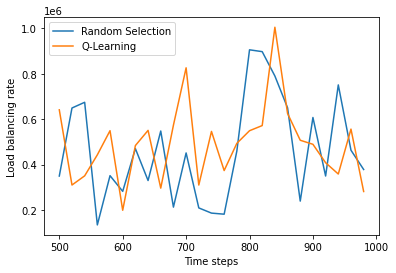

In [25]:
import matplotlib.pyplot as plt

plt.plot(x, yrandom, label='Random Selection')
# plt.plot(x,ygreedy,label='Greedy_QL')
plt.plot(x, yQl, label='Q-Learning')
plt.xlabel('Time steps')
plt.ylabel('Load balancing rate')
plt.legend()
plt.show()

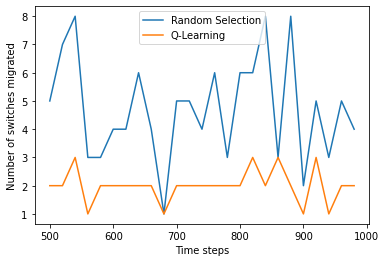

In [26]:
plt.plot(x, zrandom, label='Random Selection')
# plt.plot(x,zgreedy,label='Greedy_QL')
plt.plot(x, zQl, label='Q-Learning')
plt.xlabel('Time steps')
plt.ylabel('Number of switches migrated')
plt.legend()
plt.show()

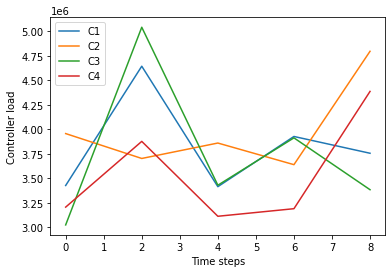

In [28]:
c1 = [[], [], [], [], []]
sc = []
for i in range(0, 10, 2):
    sc.append(i)
    e = load_controller[i]
    j = 0
    for ctrl, ctrl_load in e.items():
        c1[j].append(ctrl_load)
        j = j+1

plt.plot(sc, c1[0], label='C1')
plt.plot(sc, c1[1], label='C2')
plt.plot(sc, c1[2], label='C3')
plt.plot(sc, c1[3], label='C4')
# plt.plot(sc, c1[4], label='C5')
plt.xlabel('Time steps')
plt.ylabel('Controller load')
plt.legend()
plt.show()

In [33]:
import csv

# field names
fields = ['load_rate', 'Number of switches']

# name of csv file
filename = "Dataset_Load_random.csv"

# writing to csv file
with open(filename, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)

    # writing the fields
    csvwriter.writerow(fields)

    # writing the data rows
    csvwriter.writerows(load_rate_array)